In [1]:
# READ DATA IMPORTS

import h5py
import os
import time

# CODE HELPERS
import tensorflow as tf
import numpy as np

# DATA VISU
import matplotlib.pyplot as plt

basedir = '/mnt/dataB/cxr8'

config = tf.ConfigProto()
proto = config.gpu_options.allow_growth=True

# Data mining

Loading Data

Split into train/test

Visualization

In [2]:
def load_data(max_images=1000):
    
    with h5py.File(basedir + '/data/cxr8_512_1ch_mass.hdf5', 'r') as hdf:
        X = hdf['X'][:max_images]
        y = hdf['y'][:max_images]
        
        X = np.expand_dims(X, axis=3)
        
    return X, y

X, y = load_data()

In [3]:
def split_data(prop_test = 0.10, prop_val = 0.10):

        lim_test = int(X.shape[0]*prop_test)
        lim_val = lim_test+ int(X.shape[0]*(prop_val))

        x_train = X[:-lim_val,:,:]
        x_val = X[-lim_val:-lim_test,:,:]
        x_test = X[-lim_test:,:,:]

        y_train = y[:-lim_val]
        y_val = y[-lim_val:-lim_test]
        y_test = y[-lim_test:]

        return x_train, x_val, x_test, y_train, y_val, y_test
    
x_train, x_val, x_test, y_train, y_val, y_test = split_data()

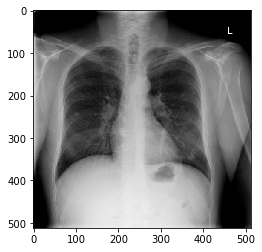

0.0


In [4]:
def show_image(x_data, idx=0):
    
    with tf.Graph().as_default():
        init = (tf.global_variables_initializer(), tf.local_variables_initializer())  

        with tf.Session(config=config) as sess:
            sess.run(init)
            img = sess.run(tf.image.grayscale_to_rgb(x_data[idx]*255)).astype(np.uint8)

        plt.imshow(img)
        plt.show()

idx = 100
show_image(x_train, idx=idx)
print(y_train[idx])

resize image if needed

In [5]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 20, 20, 1

def resize_all(data):
    
    with tf.Graph().as_default():
        init = (tf.global_variables_initializer(), tf.local_variables_initializer()) 
        with tf.Session(config=config) as sess:
                    sess.run(init)
                    processed_data = sess.run(tf.image.resize_images(data,[IMG_HEIGHT, IMG_WIDTH]))  
                    
        return processed_data

In [6]:
processed_data = resize_all(X)

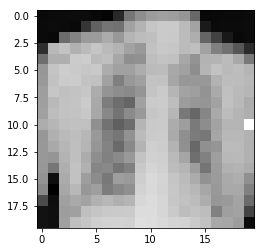

In [7]:
show_image(processed_data, idx=0)

from class labels to domain assignment

In [8]:
def split_into_class(X, y):
    
    X_a = X[np.where(y==1)]
    X_b = X[np.where(y==0)]
    
    return X_a, X_b

X_train_a, X_train_b = split_into_class(x_train, y_train)

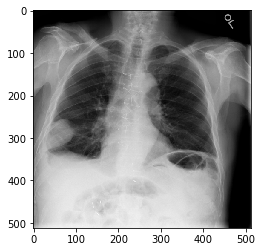

In [9]:
show_image(X_train_a,idx=1)

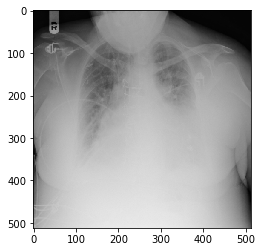

In [10]:
show_image(X_train_b,idx=1)

# Create data_processing() class

In [11]:
def resize_all(data, img_height, img_width):
    
    with tf.Graph().as_default():
                init = (tf.global_variables_initializer(), tf.local_variables_initializer())  

                with tf.Session(config=config) as sess:
                        resized_data = sess.run(tf.image.resize_images(data,[img_height, img_width]))
    
    return resized_data

    
def convert_to_rgb(data):
    
    with tf.Graph().as_default():
                init = (tf.global_variables_initializer(), tf.local_variables_initializer())  

                with tf.Session(config=config) as sess:
                        rgb_data = sess.run(tf.image.grayscale_to_rgb(data))
                        
    return rgb_data
    
def rescale_gray_levels(data, max_scale, offset):
    
     
    with tf.Graph().as_default():
                init = (tf.global_variables_initializer(), tf.local_variables_initializer())  

                with tf.Session(config=config) as sess:
                    
                    normalized_data = sess.run(tf.subtract(tf.div(data,max_scale), offset))
        
    return normalized_data

def pre_processing_manager(batch_i, img_height, img_width, resize=True, rescale_grays=True, convert_to_rgb=True):
    
    if resize:
                        batch_i = resize_all(batch_i, img_height, img_width)
                    
    if convert_to_rgb:
                        batch_i = convert_to_rgb(batch_i)
                                            
    if rescale_grays:
                        max_scale = np.max(batch_i)
                        offset = np.min(batch_i)
                             
                        batch_i = rescale_gray_levels(batch_i, max_scale, offset)
                        
    return batch_i 
                    


In [12]:
from datetime import datetime

SAVE_MAX_IMAGES = 5000
MAX_IMAGES = 100
IMG_HEIGHT = 255
IMG_WIDTH = 255
IMG_CHANNELS = 1
DEFAULT_PATH = '/mnt/dataB/cxr8/data/cxr8_512_1ch_mass.hdf5'

In [13]:
class Data_loader():
    """The CycleGAN module."""

    def __init__(self, pre_process=False, do_save=False, _data_path=DEFAULT_PATH,
                 _out_dir='./processed_data'):
        
        
        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        
        self.pre_process = pre_process
        self.do_save = do_save
        self.out_dir=_out_dir
        self.data_path = _data_path
        
        self.max_images_to_open = MAX_IMAGES
        self.max_images_to_save = SAVE_MAX_IMAGES
        
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.img_channels = IMG_CHANNELS
        self.img_size = IMG_HEIGHT*IMG_WIDTH

        
        self.normalize = True
        self.do_split = True
        self.prop_test = 0.1
        self.prop_val = 0.1
        
        self.correct_path = (self.out_dir+'/num_images='+ str(self.max_images_to_save)
                                                     +'/img_heigh=('+str(self.img_height)+
                                                    ')_img_width=('+str(self.img_width)+')'+
                                                    '_img_channels=('+str(self.img_channels)+')')
        
    
    def check_path(self):
        

        if os.path.exists(self.correct_path+'/data.h5'):

                    print('WARNING: data type already exists!!')
                    print('WARNING: to avoid time consumption, change path to true path...')
                    self.data_path = self.correct_path+'/data.h5'

                    if self.pre_process:
                        print('WARNING: nothing to preprocess, data already exists...')
                        self.pre_process=False

                    if self.do_save:                 
                        print('WARNING: nothing to save, data already exists...')
                        self.do_save=False

    

    def load_data(self):
        
        if self.do_save: self.max_images_to_open = self.max_images_to_save
    
        with h5py.File(self.data_path, 'r') as hdf:
            
            if (self.max_images_to_open > 0):
                X = hdf['X'][:self.max_images_to_open]
                _y = hdf['y'][:self.max_images_to_open]
            else:
                X = hdf['X'][:]
                _y = hdf['y'][:]

            if X.ndim < 4: 
                self.unprocessed_X = np.expand_dims(X, axis=3)
            else:
                self.unprocessed_X = X
                
            self.y = _y
            self.unprocessed_size = (self.unprocessed_X.shape[1]*
                                     self.unprocessed_X.shape[2])
            
            ###### create pseudo processed template
            self.processed_X = self.unprocessed_X
    

    def pre_process_data(self):
        
        # check for big data case
        self.total_num_images = self.unprocessed_X.shape[0]
        big_data = (self.total_num_images > 1000)
        
        # processing conditions
        resize = self.img_size != self.unprocessed_size
        rescale_grays = self.normalize
        convert_to_rgb = (self.img_channels == 3) & (self.unprocessed_X.shape[3] != 3)
        
        
        if big_data:

                print('WARNING: processing big data will be time consuming')
                print('total number of images to treat :', self.total_num_images)
    
                batch_list = []
                n_batches = int(self.total_num_images/1000)
    
                for i in range(0, n_batches):
                    
                    batch_i = self.processed_X[i*1000:(i+1)*1000]
                    batch_i = pre_processing_manager(batch_i, self.img_height, self.img_width,
                                                     resize=resize, rescale_grays=rescale_grays,
                                                     convert_to_rgb=convert_to_rgb)
                    batch_list.append(batch_i)
                    
                    if (i==n_batches-1) & ((i+1)*1000 < self.total_num_images): 
                        
                        last_batch = self.processed_X[(i+1)*1000:]
                        last_batch = pre_processing_manager(last_batch, self.img_height, self.img_width,
                                                     resize=resize, rescale_grays=rescale_grays,
                                                     convert_to_rgb=convert_to_rgb)
                        batch_list.append(last_batch)
                        
                self.processed_X = np.concatenate(batch_list, axis=0)
                
        else:
                
                self.processed_X = pre_processing_manager(self.processed_X, self.img_height, self.img_width,
                                                     resize=resize, rescale_grays=rescale_grays,
                                                     convert_to_rgb=convert_to_rgb)
                
        
        

       
    
    def format_to_classes(self):                      
       
           self.processed_a = self.processed_X[np.where(self.y==1)]
           self.processed_b = self.processed_X[np.where(self.y==0)]
        
    
    def split_data(self): 
            
            # CLASS A SPLIT
            lim_test = int(self.processed_a.shape[0]*self.prop_test)
            lim_val = lim_test+ int(self.processed_a.shape[0]*(self.prop_val))

            self.a_train = self.processed_a[:-lim_val,:,:]
            self.a_val = self.processed_a[-lim_val:-lim_test,:,:]
            self.a_test = self.processed_a[-lim_test:,:,:]
            
            # CLASS B SPLIT
            lim_test = int(self.processed_b.shape[0]*self.prop_test)
            lim_val = lim_test+ int(self.processed_b.shape[0]*(self.prop_val))
            
            self.b_train = self.processed_b[:-lim_val,:,:]
            self.b_val = self.processed_b[-lim_val:-lim_test,:,:]
            self.b_test = self.processed_b[-lim_test:,:,:]
            
            #FULL DATA SPLIT
            
            lim_test = int(self.processed_X.shape[0]*self.prop_test)
            lim_val = lim_test+ int(self.processed_X.shape[0]*(self.prop_val))
            
            self.x_train = self.processed_X[:-lim_val,:,:]
            self.x_val = self.processed_X[-lim_val:-lim_test,:,:]
            self.x_test = self.processed_X[-lim_test:,:,:]
            
            self.y_train = self.y[:-lim_val]
            self.y_val = self.y[-lim_val:-lim_test]
            self.y_test = self.y[-lim_test:]

            
            
    def  build_data(self):
            
            if (self.pre_process) or (self.do_save):
                            print('checking data path...')
                            self.check_path()
                             
            
            #Load data
            print('loading data...')
            self.load_data()

            if self.pre_process:
                            print('processing data...')
                            self.pre_process_data()
                        
            if self.do_save:
                            print('saving processed data...')
                            
                            os.makedirs(self.correct_path)
                            
                            h5f = h5py.File(self.correct_path+'/data.h5', 'w')
   
                            h5f.create_dataset('X', data=self.processed_X)
                            h5f.create_dataset('y', data=self.y)
                            h5f.close()
        
            # Always format to classes
            self.format_to_classes()
                             
            if self.do_split:
                             print('splitting data for validation...')
                             self.split_data()

    
    

In [14]:
_data_loader = Data_loader(pre_process=True, do_save=True)
_data_loader.build_data()

checking data path...
loading data...
splitting data for validation...


In [15]:
imgs = _data_loader.b_val

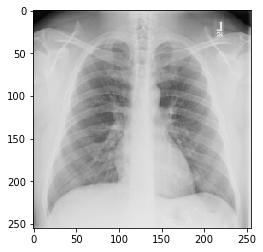

In [16]:
show_image(imgs,idx=1)

# From one to several classes

In [3]:
def load_data_multi_class(max_images=1000):
    
    with h5py.File(basedir + '/data/cxr8_512_1ch_mass.hdf5', 'r') as hdf:
        X = hdf['X'][:max_images]
        y = hdf['y'][:max_images]
        
        X = np.expand_dims(X, axis=3)
        
    return X, y

X, y = load_data_multi_class()

In [4]:
X_a = X[np.where(y != 0)]
X_b = X[np.where(y == 0)]
y_a = y[np.where(y != 0)]
y_b = y[np.where(y == 0)]

In [5]:
len(y_a), X_a.shape

(376, (376, 512, 512, 1))